In [2]:
import tkinter as tk
from tkinter import messagebox, filedialog
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.metrics import f1_score, accuracy_score

class SimpleImageEvaluatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Breast Cancer Diagnosis")
        self.root.geometry("800x600")
        self.root.configure(bg="#001f3f")  # Màu nền chủ đạo

        self.checkpoint_file = ""
        self.image_path = ""
        self.model = None
        self.f1_score = 0
        self.accuracy = 0

        # Layout
        self.create_widgets()

    def create_widgets(self):
        # Khung bên trái với viền
        left_frame = tk.Frame(self.root, bg="#001f3f", bd=2, relief=tk.SUNKEN)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=10, pady=10)

        tk.Label(left_frame, text="Select Image:", bg="#001f3f", fg="white").grid(row=0, column=0, padx=10, pady=10, sticky='w')
        self.image_entry = tk.Entry(left_frame, width=40)
        self.image_entry.grid(row=0, column=1, padx=10, pady=10, sticky='ew')
        tk.Button(left_frame, text="Browse", command=self.browse_image, bg="#0074D9", fg="white").grid(row=0, column=2, padx=10, pady=10)

        tk.Label(left_frame, text="Select Model Checkpoint:", bg="#001f3f", fg="white").grid(row=1, column=0, padx=10, pady=10, sticky='w')
        self.checkpoint_entry = tk.Entry(left_frame, width=40)
        self.checkpoint_entry.grid(row=1, column=1, padx=10, pady=10, sticky='ew')
        tk.Button(left_frame, text="Load Checkpoint", command=self.load_checkpoint, bg="#0074D9", fg="white").grid(row=1, column=2, padx=10, pady=10)

        tk.Button(left_frame, text="Evaluate", command=self.evaluate_image, bg="#FF4136", fg="white").grid(row=2, column=0, columnspan=3, padx=10, pady=20)

        # Hình ảnh và xác suất
        self.image_label = tk.Label(left_frame, bg="#001f3f")
        self.image_label.grid(row=3, column=0, columnspan=3, pady=10)

        self.result_label = tk.Label(left_frame, bg="#001f3f", fg="white", font=("Helvetica", 14))
        self.result_label.grid(row=4, column=0, columnspan=3, pady=10)

        self.result_prob_label = tk.Label(left_frame, bg="#001f3f", fg="white", font=("Helvetica", 12))
        self.result_prob_label.grid(row=5, column=0, columnspan=3, pady=10)

        # Khung bên phải với viền
        right_frame = tk.Frame(self.root, bg="#001f3f", bd=2, relief=tk.SUNKEN)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)

        self.metric_option = tk.StringVar(value="Bar Chart")  # Mặc định chọn biểu đồ cột
        tk.OptionMenu(right_frame, self.metric_option, "Bar Chart", "Line Chart", "Pie Chart").pack(pady=10)

        self.plot_button = tk.Button(right_frame, text="Show Metrics", command=self.plot_metrics, bg="#0074D9", fg="white")
        self.plot_button.pack(side=tk.TOP, pady=10)

        # Canvas cho biểu đồ
        self.canvas = None

        self.root.minsize(width=1100, height=600)  # Đặt kích thước tối thiểu cho cửa sổ chính

    def browse_image(self):
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
        if self.image_path:
            self.image_entry.delete(0, tk.END)
            self.image_entry.insert(0, self.image_path)

    def load_checkpoint(self):
        self.checkpoint_file = filedialog.askopenfilename(filetypes=[("Keras Model", "*.keras")])
        if self.checkpoint_file:
            self.checkpoint_entry.delete(0, tk.END)
            self.checkpoint_entry.insert(0, self.checkpoint_file)

    def evaluate_image(self):
        if not self.image_path or not self.checkpoint_file:
            messagebox.showerror("Error", "Please select both an image and a model checkpoint.")
            return

        # Load model
        try:
            self.model = load_model(self.checkpoint_file)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model from {self.checkpoint_file}: {e}")
            return

        # Load and preprocess the image
        try:
            image = Image.open(self.image_path)
            image = image.resize((224, 224))  # Thay đổi kích thước theo yêu cầu của mô hình
            self.display_image(image)  # Hiển thị ảnh đã upload

            image_array = np.array(image) / 255.0  # Chuẩn hóa
            image_array = np.expand_dims(image_array, axis=0)  # Thêm kích thước batch

            # Make prediction
            predictions = self.model.predict(image_array)
            predicted_class = np.argmax(predictions, axis=1)
            class_probabilities = predictions[0]  # Lấy xác suất cho lớp

            # Giới hạn xác suất lớp
            class_probabilities = [f"{prob:.3f}" for prob in class_probabilities]

            # Hiển thị kết quả
            self.result_label.config(text=f"Predicted class: {predicted_class[0]}")
            self.result_prob_label.config(text=f"Probabilities: {', '.join(class_probabilities)}")

            # Tính F1 score và accuracy (giả sử true_labels là nhãn đúng)
            true_labels = np.array([1, 0, 0, 0])  # Giả sử bạn có nhãn đúng cho ví dụ này
            f1 = f1_score(true_labels, (predictions > 0.5).astype(int), average='weighted')
            accuracy = accuracy_score(true_labels, (predictions > 0.5).astype(int))

            self.f1_score = f1
            self.accuracy = accuracy

        except Exception as e:
            messagebox.showerror("Error", f"Error processing image: {e}")

    def display_image(self, image):
        """Hiển thị ảnh trong giao diện."""
        image = ImageTk.PhotoImage(image)
        self.image_label.config(image=image)
        self.image_label.image = image  # Giữ tham chiếu đến ảnh

    def plot_metrics(self):
        """Hiển thị biểu đồ dựa trên lựa chọn của người dùng."""
        if self.model is None:
            messagebox.showerror("Error", "Please evaluate an image first.")
            return

        # Xóa canvas cũ nếu có
        if self.canvas:
            self.canvas.get_tk_widget().destroy()

        # Giả sử bạn đã lưu class_probabilities trong evaluate_image
        class_probabilities = self.model.predict(np.expand_dims(np.array(Image.open(self.image_path).resize((224, 224))) / 255.0, axis=0))[0]
        classes = [f'Class {i}' for i in range(len(class_probabilities))]

        # Tạo màu sắc ngẫu nhiên cho từng cột
        colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))

        fig, ax = plt.subplots(figsize=(6, 4))  # Tạo figure cho matplotlib

        metric_type = self.metric_option.get()  # Lấy loại biểu đồ đã chọn

        if metric_type == "Bar Chart":
            bars = ax.bar(classes, class_probabilities, color=colors)
            ax.set_ylim(0, 1)  # Giới hạn giá trị từ 0 đến 1
            ax.set_title("Predicted Class Probabilities")
            ax.set_ylabel("Probability")
            ax.grid(axis='y')

            # Hiển thị số xác suất trên đầu mỗi cột
            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.3f}", ha='center', va='bottom')

        elif metric_type == "Line Chart":
            ax.plot(classes, class_probabilities, marker='o', color='blue')
            ax.set_ylim(0, 1)  # Giới hạn giá trị từ 0 đến 1
            ax.set_title("Predicted Class Probabilities (Line Chart)")
            ax.set_ylabel("Probability")
            ax.grid()

        elif metric_type == "Pie Chart":
            ax.pie(class_probabilities, labels=classes, autopct='%1.1f%%', startangle=140)
            ax.set_title("Predicted Class Probabilities (Pie Chart)")

        # Tạo canvas cho matplotlib
        self.canvas = FigureCanvasTkAgg(fig, master=self.root)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleImageEvaluatorApp(root)
    root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


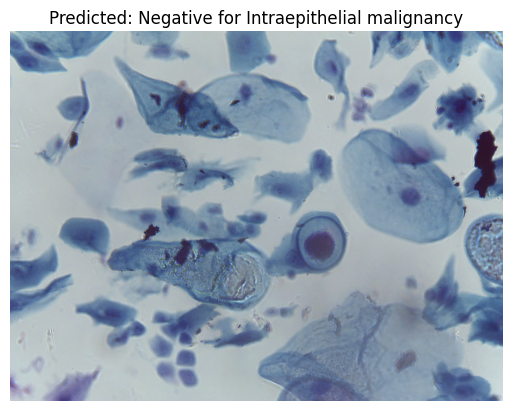

In [8]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNetV3_Large_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\utvtest.jpg'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    img_array /= 255.0  # Chuẩn hóa ảnh nếu cần
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


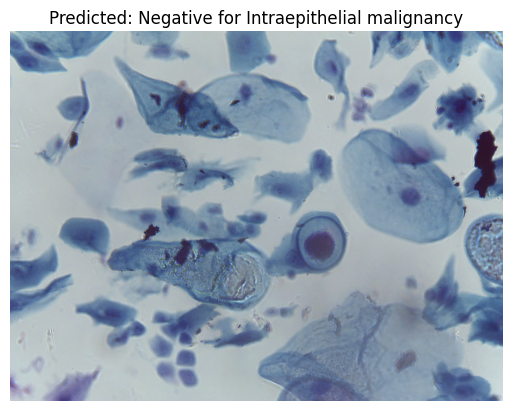

In [9]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V3_Small_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\utvtest.jpg'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    img_array /= 255.0  # Chuẩn hóa ảnh nếu cần
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


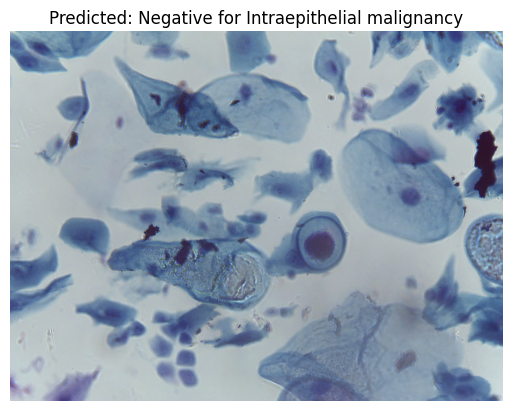

In [10]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V1_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\utvtest.jpg'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    img_array /= 255.0  # Chuẩn hóa ảnh nếu cần
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


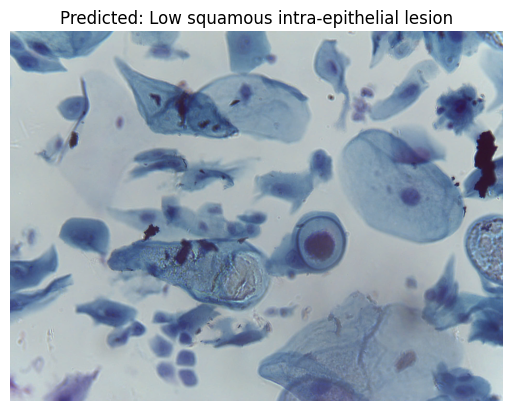

In [11]:



import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V2_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\utvtest.jpg'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    img_array /= 255.0  # Chuẩn hóa ảnh nếu cần
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


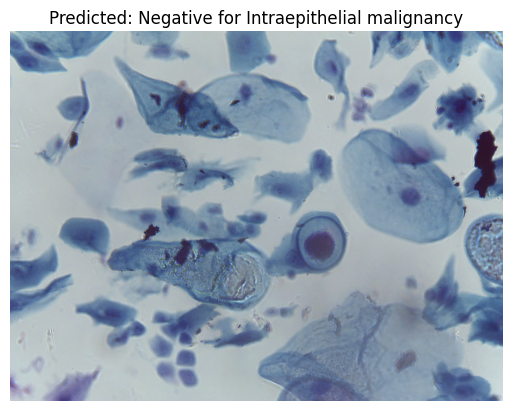

In [15]:



import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'efficientNet_B0_aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\utvtest.jpg'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    img_array /= 255.0  # Chuẩn hóa ảnh nếu cần
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


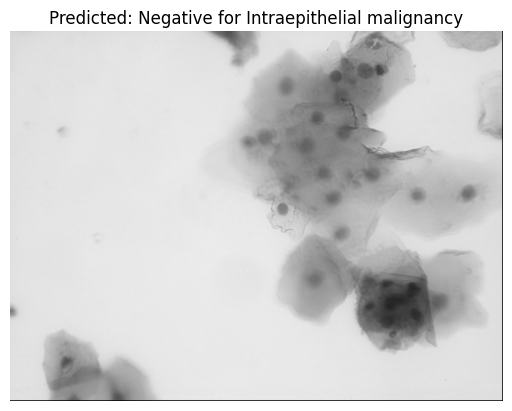

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V1_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\fov004.png'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    img_array /= 255.0  # Chuẩn hóa ảnh nếu cần
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


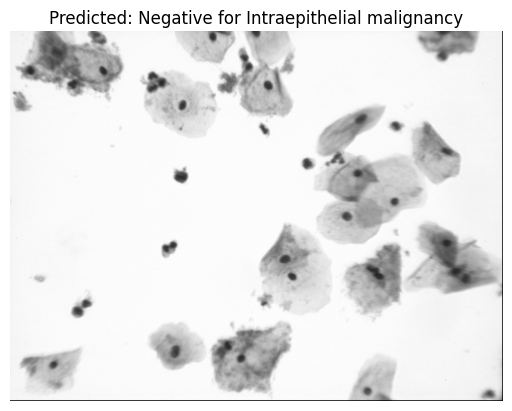

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V1_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\fov005.png'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    img_array /= 255.0  # Chuẩn hóa ảnh nếu cần
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


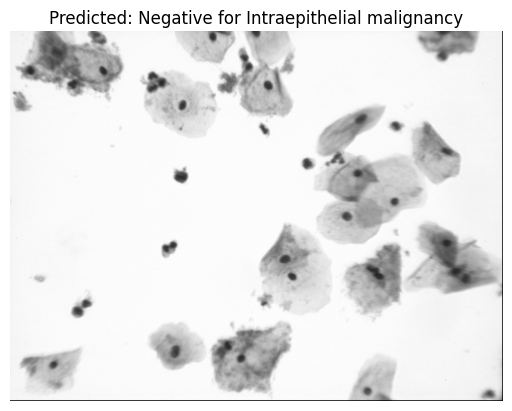

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V1_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\fov005.png'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào với lớp Rescaling
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

def preprocess_image(img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch
    
    # Áp dụng lớp Rescaling
    img_array = rescale(img_array)
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


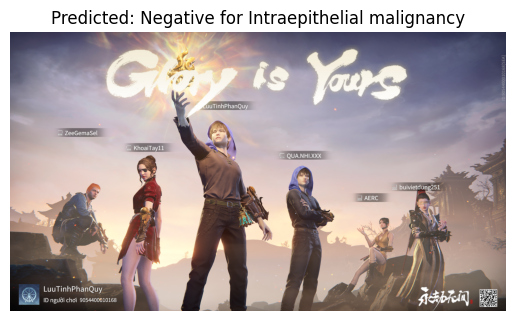

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import ImageOps

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V1_Aug.keras'
IMAGE_PATH = 'C:\\Users\\ADMIN\\OneDrive\\Pictures\\63859178956349.png'

# Đường dẫn tới các thư mục lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào của mô hình

# Tải mô hình từ file .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Hàm tiền xử lý ảnh đầu vào với lớp Rescaling
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

def preprocess_image(img_path, img_size=IMG_SIZE):
    # Tải ảnh với kích thước chỉ định
    img = image.load_img(img_path, color_mode='rgb', target_size=img_size)
    
    # Chuyển ảnh về mảng numpy
    img_array = image.img_to_array(img)
    
    # Thêm chiều batch
    img_array = tf.expand_dims(img_array, 0)
    
    # Áp dụng lớp Rescaling để chuẩn hóa ảnh
    img_array = rescale(img_array)
    return img_array

# Tải và tiền xử lý ảnh
input_image = preprocess_image(IMAGE_PATH)

# Dự đoán lớp của ảnh
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(image.load_img(IMAGE_PATH))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


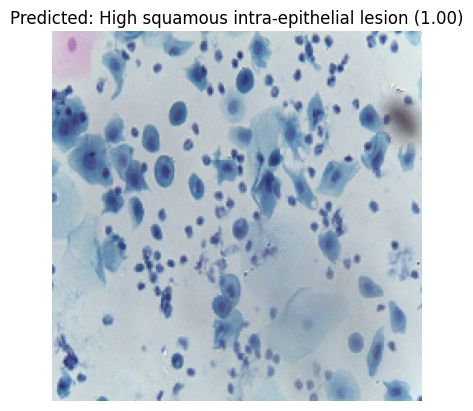

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Đường dẫn tới mô hình đã lưu và ảnh muốn dự đoán
MODEL_PATH = 'mobileNet_V2_Aug.keras'
IMAGE_PATH = 'D:\\AnacondaPython\\NCKH\\zddtpgzv63-4\\High squamous intra-epithelial lesion\\LSIL.jpg'

# Danh sách tên các lớp
class_names = [
    'High squamous intra-epithelial lesion', 
    'Low squamous intra-epithelial lesion', 
    'Negative for Intraepithelial malignancy', 
    'Squamous cell carcinoma'
]

IMG_SIZE = (224, 224)

# Tải mô hình từ checkpoint
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

# Tiền xử lý và tải ảnh đầu vào
img = image.load_img(IMAGE_PATH, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Tạo batch với kích thước (1, IMG_SIZE[0], IMG_SIZE[1], 3)

# Dự đoán trên ảnh đầu vào
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence_score = np.max(predictions)  # Độ tin cậy của dự đoán

# Hiển thị ảnh và kết quả dự đoán
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence_score:.2f})")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


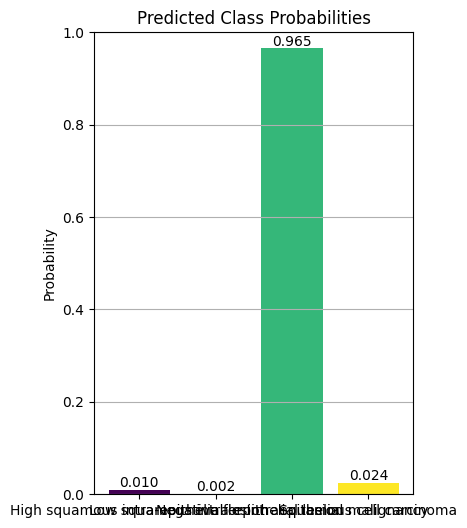

In [27]:
import tkinter as tk
from tkinter import messagebox, filedialog
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class SimpleImageEvaluatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Breast Cancer Diagnosis")
        self.root.geometry("800x600")
        self.root.configure(bg="#001f3f")  # Màu nền chủ đạo

        self.checkpoint_file = ""
        self.image_path = ""
        self.model = None

        # Layout
        self.create_widgets()

    def create_widgets(self):
        # Khung bên trái với viền
        left_frame = tk.Frame(self.root, bg="#001f3f", bd=2, relief=tk.SUNKEN)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=10, pady=10)

        tk.Label(left_frame, text="Select Image:", bg="#001f3f", fg="white").grid(row=0, column=0, padx=10, pady=10, sticky='w')
        self.image_entry = tk.Entry(left_frame, width=40)
        self.image_entry.grid(row=0, column=1, padx=10, pady=10, sticky='ew')
        tk.Button(left_frame, text="Browse", command=self.browse_image, bg="#0074D9", fg="white").grid(row=0, column=2, padx=10, pady=10)

        tk.Label(left_frame, text="Select Model Checkpoint:", bg="#001f3f", fg="white").grid(row=1, column=0, padx=10, pady=10, sticky='w')
        self.checkpoint_entry = tk.Entry(left_frame, width=40)
        self.checkpoint_entry.grid(row=1, column=1, padx=10, pady=10, sticky='ew')
        tk.Button(left_frame, text="Load Checkpoint", command=self.load_checkpoint, bg="#0074D9", fg="white").grid(row=1, column=2, padx=10, pady=10)

        tk.Button(left_frame, text="Evaluate", command=self.evaluate_image, bg="#FF4136", fg="white").grid(row=2, column=0, columnspan=3, padx=10, pady=20)

        # Hình ảnh và xác suất
        self.image_label = tk.Label(left_frame, bg="#001f3f")
        self.image_label.grid(row=3, column=0, columnspan=3, pady=10)

        self.result_label = tk.Label(left_frame, bg="#001f3f", fg="white", font=("Helvetica", 14))
        self.result_label.grid(row=4, column=0, columnspan=3, pady=10)

        self.result_prob_label = tk.Label(left_frame, bg="#001f3f", fg="white", font=("Helvetica", 12))
        self.result_prob_label.grid(row=5, column=0, columnspan=3, pady=10)

        # Khung bên phải với viền
        right_frame = tk.Frame(self.root, bg="#001f3f", bd=2, relief=tk.SUNKEN)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)

        self.metric_option = tk.StringVar(value="Bar Chart")  # Mặc định chọn biểu đồ cột
        tk.OptionMenu(right_frame, self.metric_option, "Bar Chart", "Line Chart", "Pie Chart").pack(pady=10)

        self.plot_button = tk.Button(right_frame, text="Show Metrics", command=self.plot_metrics, bg="#0074D9", fg="white")
        self.plot_button.pack(side=tk.TOP, pady=10)

        # Canvas cho biểu đồ
        self.canvas = None

        self.root.minsize(width=1100, height=600)  # Đặt kích thước tối thiểu cho cửa sổ chính

    def browse_image(self):
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
        if self.image_path:
            self.image_entry.delete(0, tk.END)
            self.image_entry.insert(0, self.image_path)

    def load_checkpoint(self):
        self.checkpoint_file = filedialog.askopenfilename(filetypes=[("Keras Model", "*.keras")])
        if self.checkpoint_file:
            self.checkpoint_entry.delete(0, tk.END)
            self.checkpoint_entry.insert(0, self.checkpoint_file)

    def evaluate_image(self):
        if not self.image_path or not self.checkpoint_file:
            messagebox.showerror("Error", "Please select both an image and a model checkpoint.")
            return

        # Load model
        try:
            self.model = load_model(self.checkpoint_file)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model from {self.checkpoint_file}: {e}")
            return

        # Load and preprocess the image
        try:
            image = Image.open(self.image_path)
            image = image.resize((224, 224))  # Thay đổi kích thước theo yêu cầu của mô hình
            self.display_image(image)  # Hiển thị ảnh đã upload

            image_array = np.array(image) / 255.0  # Chuẩn hóa
            image_array = np.expand_dims(image_array, axis=0)  # Thêm kích thước batch

            # Make prediction
            predictions = self.model.predict(image_array)
            predicted_class = np.argmax(predictions, axis=1)
            class_probabilities = predictions[0]  # Lấy xác suất cho lớp

            # Giới hạn xác suất lớp
            class_probabilities = [f"{prob:.3f}" for prob in class_probabilities]

            # Hiển thị kết quả
            self.result_label.config(text=f"Predicted class: {predicted_class[0]}")
            self.result_prob_label.config(text=f"Probabilities: {', '.join(class_probabilities)}")

        except Exception as e:
            messagebox.showerror("Error", f"Error processing image: {e}")

    def display_image(self, image):
        """Hiển thị ảnh trong giao diện."""
        image = ImageTk.PhotoImage(image)
        self.image_label.config(image=image)
        self.image_label.image = image  # Giữ tham chiếu đến ảnh

    def plot_metrics(self):
        """Hiển thị biểu đồ dựa trên lựa chọn của người dùng."""
        if self.model is None:
            messagebox.showerror("Error", "Please evaluate an image first.")
            return

        # Xóa canvas cũ nếu có
        if self.canvas:
            self.canvas.get_tk_widget().destroy()

        # Dự đoán xác suất cho lớp
        class_probabilities = self.model.predict(np.expand_dims(np.array(Image.open(self.image_path).resize((224, 224))) / 255.0, axis=0))[0]
        classes = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 
                   'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']

        # Tạo màu sắc ngẫu nhiên cho từng cột
        colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))

        fig, ax = plt.subplots(figsize=(6, 4))  # Tạo figure cho matplotlib

        metric_type = self.metric_option.get()  # Lấy loại biểu đồ đã chọn

        if metric_type == "Bar Chart":
            bars = ax.bar(classes, class_probabilities, color=colors)
            ax.set_ylim(0, 1)  # Giới hạn giá trị từ 0 đến 1
            ax.set_title("Predicted Class Probabilities")
            ax.set_ylabel("Probability")
            ax.grid(axis='y')

            # Hiển thị số xác suất trên đầu mỗi cột
            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.3f}", ha='center', va='bottom')

        elif metric_type == "Line Chart":
            ax.plot(classes, class_probabilities, marker='o', color='blue')
            ax.set_ylim(0, 1)  # Giới hạn giá trị từ 0 đến 1
            ax.set_title("Predicted Class Probabilities (Line Chart)")
            ax.set_ylabel("Probability")
            ax.grid()

        elif metric_type == "Pie Chart":
            ax.pie(class_probabilities, labels=classes, autopct='%1.1f%%', startangle=140)
            ax.set_title("Predicted Class Probabilities (Pie Chart)")

        # Tạo canvas cho matplotlib
        self.canvas = FigureCanvasTkAgg(fig, master=self.root)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleImageEvaluatorApp(root)
    root.mainloop()


In [33]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import Label
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image, ImageTk

class SimpleImageEvaluatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Simple Image Evaluator")
        self.root.geometry("800x600")
        self.root.configure(bg="#87CEEB")  # Xanh biển nhạt

        self.image_path = None
        self.checkpoint_file = None
        self.model = None

        # Left panel - Upload controls
        self.upload_frame = tk.Frame(self.root, bg="#87CEEB")
        self.upload_frame.pack(side="left", padx=10, pady=10)

        # Image upload button
        self.upload_image_button = tk.Button(
            self.upload_frame, text="Upload Image", command=self.select_image
        )
        self.upload_image_button.pack(pady=5)

        # Model checkpoint upload button
        self.upload_model_button = tk.Button(
            self.upload_frame, text="Upload Model Checkpoint", command=self.select_checkpoint
        )
        self.upload_model_button.pack(pady=5)

        # Evaluation button
        self.evaluate_button = tk.Button(
            self.upload_frame, text="Evaluate Image", command=self.evaluate_image
        )
        self.evaluate_button.pack(pady=5)

        # Right panel - Display controls
        self.display_frame = tk.Frame(self.root, bg="#87CEEB")
        self.display_frame.pack(side="right", padx=10, pady=10)

        # Image display label
        self.image_label = Label(self.display_frame)
        self.image_label.pack()

        # Result display labels
        self.result_label = tk.Label(self.display_frame, text="", font=("Arial", 16), bg="#87CEEB")
        self.result_label.pack(pady=5)

        self.result_prob_label = tk.Label(self.display_frame, text="", font=("Arial", 14), bg="#87CEEB")
        self.result_prob_label.pack(pady=5)

    def select_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp")]
        )
        if file_path:
            self.image_path = file_path
            self.display_image(file_path)

    def display_image(self, img_path):
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Đảm bảo ảnh có kích thước phù hợp để hiển thị
        img = ImageTk.PhotoImage(img)
        self.image_label.configure(image=img)
        self.image_label.image = img  # Giữ tham chiếu để tránh bị xoá bởi bộ dọn rác

    def select_checkpoint(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Model Checkpoint", "*.h5"), ("Keras Model", "*.keras")]
        )
        if file_path:
            self.checkpoint_file = file_path

    def evaluate_image(self):
        if not self.image_path or not self.checkpoint_file:
            messagebox.showerror("Error", "Please select both an image and a model checkpoint.")
            return

        # Load model
        try:
            self.model = load_model(self.checkpoint_file)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model from {self.checkpoint_file}: {e}")
            return

        # Load and preprocess the image
        try:
            img = image.load_img(self.image_path, target_size=(224, 224))  # Kích thước đầu vào của mô hình
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, 0)  # Batch size = 1

            # Make prediction
            predictions = self.model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)[0]
            confidence_score = np.max(predictions)

            # Display the result
            class_names = [
                'High squamous intra-epithelial lesion',
                'Low squamous intra-epithelial lesion',
                'Negative for Intraepithelial malignancy',
                'Squamous cell carcinoma'
            ]
            self.result_label.config(text=f"Predicted: {class_names[predicted_class]}")
            self.result_prob_label.config(text=f"Confidence: {confidence_score:.2f}")

        except Exception as e:
            messagebox.showerror("Error", f"Error processing image: {e}")

# Main application
if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleImageEvaluatorApp(root)
    root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


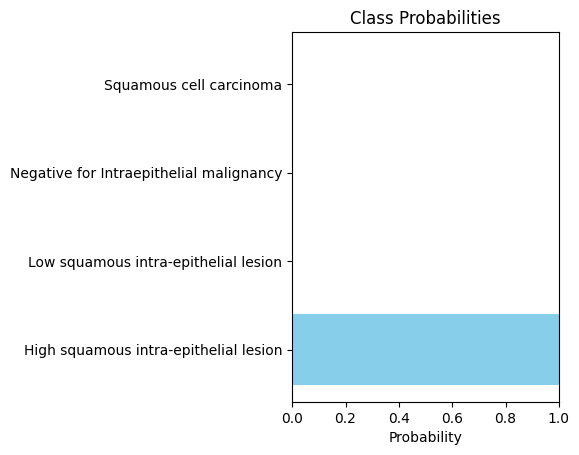

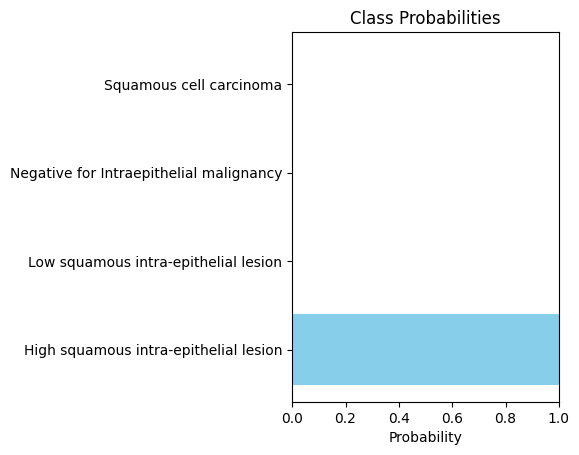

In [34]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import Label
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class SimpleImageEvaluatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Simple Image Evaluator")
        self.root.geometry("1000x600")  # Tăng chiều rộng
        self.root.configure(bg="#87CEEB")  # Xanh biển nhạt

        self.image_path = None
        self.checkpoint_file = None
        self.model = None
        self.predictions = None

        # Left panel - Upload controls
        self.upload_frame = tk.Frame(self.root, bg="#87CEEB")
        self.upload_frame.pack(side="left", padx=10, pady=10)

        # Image upload button
        self.upload_image_button = tk.Button(
            self.upload_frame, text="Upload Image", command=self.select_image
        )
        self.upload_image_button.pack(pady=5)

        # Model checkpoint upload button
        self.upload_model_button = tk.Button(
            self.upload_frame, text="Upload Model Checkpoint", command=self.select_checkpoint
        )
        self.upload_model_button.pack(pady=5)

        # Evaluation button
        self.evaluate_button = tk.Button(
            self.upload_frame, text="Evaluate Image", command=self.evaluate_image
        )
        self.evaluate_button.pack(pady=5)

        # Right panel - Display controls
        self.display_frame = tk.Frame(self.root, bg="#87CEEB")
        self.display_frame.pack(side="right", padx=10, pady=10)

        # Image display label
        self.image_label = Label(self.display_frame)
        self.image_label.pack()

        # Result display labels
        self.result_label = tk.Label(self.display_frame, text="", font=("Arial", 16), bg="#87CEEB")
        self.result_label.pack(pady=5)

        self.result_prob_label = tk.Label(self.display_frame, text="", font=("Arial", 14), bg="#87CEEB")
        self.result_prob_label.pack(pady=5)

        # Frame for displaying the probability chart
        self.chart_frame = tk.Frame(self.root, bg="#87CEEB")
        self.chart_frame.pack(side="bottom", padx=10, pady=10)

    def select_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp")]
        )
        if file_path:
            self.image_path = file_path
            self.display_image(file_path)

    def display_image(self, img_path):
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Đảm bảo ảnh có kích thước phù hợp để hiển thị
        img = ImageTk.PhotoImage(img)
        self.image_label.configure(image=img)
        self.image_label.image = img  # Giữ tham chiếu để tránh bị xoá bởi bộ dọn rác

    def select_checkpoint(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Model Checkpoint", "*.h5"), ("Keras Model", "*.keras")]
        )
        if file_path:
            self.checkpoint_file = file_path

    def evaluate_image(self):
        if not self.image_path or not self.checkpoint_file:
            messagebox.showerror("Error", "Please select both an image and a model checkpoint.")
            return

        # Load model
        try:
            self.model = load_model(self.checkpoint_file)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model from {self.checkpoint_file}: {e}")
            return

        # Load and preprocess the image
        try:
            img = image.load_img(self.image_path, target_size=(224, 224))  # Kích thước đầu vào của mô hình
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, 0)  # Batch size = 1

            # Make prediction
            self.predictions = self.model.predict(img_array)
            predicted_class = np.argmax(self.predictions, axis=1)[0]
            confidence_score = np.max(self.predictions)

            # Display the result
            class_names = [
                'High squamous intra-epithelial lesion',
                'Low squamous intra-epithelial lesion',
                'Negative for Intraepithelial malignancy',
                'Squamous cell carcinoma'
            ]
            self.result_label.config(text=f"Predicted: {class_names[predicted_class]}")
            self.result_prob_label.config(text=f"Confidence: {confidence_score:.2f}")

            # Call method to display the chart
            self.plot_probabilities()

        except Exception as e:
            messagebox.showerror("Error", f"Error processing image: {e}")

    def plot_probabilities(self):
        # Clear previous chart if any
        for widget in self.chart_frame.winfo_children():
            widget.destroy()

        # Create a bar chart for probabilities
        fig, ax = plt.subplots()
        ax.barh(['High squamous intra-epithelial lesion',
                  'Low squamous intra-epithelial lesion',
                  'Negative for Intraepithelial malignancy',
                  'Squamous cell carcinoma'],
                 self.predictions[0], color='skyblue')
        ax.set_xlim(0, 1)
        ax.set_xlabel('Probability')
        ax.set_title('Class Probabilities')

        # Create a canvas to display the chart in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=self.chart_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

# Main application
if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleImageEvaluatorApp(root)
    root.mainloop()


In [37]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import Label
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class SimpleImageEvaluatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Simple Image Evaluator")
        self.root.geometry("1000x600")  # Tăng chiều rộng
        self.root.configure(bg="#87CEEB")  # Xanh biển nhạt

        self.image_path = None
        self.checkpoint_file = None
        self.model = None
        self.predictions = None

        # Left panel - Upload controls
        self.upload_frame = tk.Frame(self.root, bg="#87CEEB")
        self.upload_frame.pack(side="left", padx=10, pady=10, fill='y')

        # Image upload button
        self.upload_image_button = tk.Button(
            self.upload_frame, text="Upload Image", command=self.select_image
        )
        self.upload_image_button.pack(pady=5)

        # Model checkpoint upload button
        self.upload_model_button = tk.Button(
            self.upload_frame, text="Upload Model Checkpoint", command=self.select_checkpoint
        )
        self.upload_model_button.pack(pady=5)

        # Evaluation button
        self.evaluate_button = tk.Button(
            self.upload_frame, text="Evaluate Image", command=self.evaluate_image
        )
        self.evaluate_button.pack(pady=5)

        # Right panel - Display controls
        self.display_frame = tk.Frame(self.root, bg="#87CEEB")
        self.display_frame.pack(side="right", padx=10, pady=10, fill='both', expand=True)

        # Image display label
        self.image_label = Label(self.display_frame)
        self.image_label.pack(expand=True)

        # Result display labels
        self.result_label = tk.Label(self.display_frame, text="", font=("Arial", 16), bg="#87CEEB")
        self.result_label.pack(pady=5)

        self.result_prob_label = tk.Label(self.display_frame, text="", font=("Arial", 14), bg="#87CEEB")
        self.result_prob_label.pack(pady=5)

        # Frame for displaying the probability chart
        self.chart_frame = tk.Frame(self.root, bg="#87CEEB")
        self.chart_frame.pack(side="bottom", padx=10, pady=10, fill='both', expand=True)

    def select_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp")]
        )
        if file_path:
            self.image_path = file_path
            self.display_image(file_path)

    def display_image(self, img_path):
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Đảm bảo ảnh có kích thước phù hợp để hiển thị
        img = ImageTk.PhotoImage(img)
        self.image_label.configure(image=img)
        self.image_label.image = img  # Giữ tham chiếu để tránh bị xoá bởi bộ dọn rác

    def select_checkpoint(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Model Checkpoint", "*.h5"), ("Keras Model", "*.keras")]
        )
        if file_path:
            self.checkpoint_file = file_path

    def evaluate_image(self):
        if not self.image_path or not self.checkpoint_file:
            messagebox.showerror("Error", "Please select both an image and a model checkpoint.")
            return

        # Load model
        try:
            self.model = load_model(self.checkpoint_file)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model from {self.checkpoint_file}: {e}")
            return

        # Load and preprocess the image
        try:
            img = image.load_img(self.image_path, target_size=(224, 224))  # Kích thước đầu vào của mô hình
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, 0)  # Batch size = 1

            # Make prediction
            self.predictions = self.model.predict(img_array)
            predicted_class = np.argmax(self.predictions, axis=1)[0]
            confidence_score = np.max(self.predictions)

            # Display the result
            class_names = [
                'High lesion',
                'Low lesion',
                'Negative',
                'Carcinoma'
            ]
            self.result_label.config(text=f"Predicted: {class_names[predicted_class]}")
            self.result_prob_label.config(text=f"Confidence: {confidence_score:.2f}")

            # Call method to display the chart
            self.plot_probabilities()

        except Exception as e:
            messagebox.showerror("Error", f"Error processing image: {e}")

    def plot_probabilities(self):
        # Clear previous chart if any
        for widget in self.chart_frame.winfo_children():
            widget.destroy()

        # Create a bar chart for probabilities
        fig, ax = plt.subplots()
        ax.bar(['High lesion', 'Low lesion', 'Negative', 'Carcinoma'],  # Trục x
               self.predictions[0], color='skyblue')  # Trục y
        ax.set_ylim(0, 1)  # Thiết lập giới hạn cho trục y
        ax.set_ylabel('Probability')  # Nhãn cho trục y
        ax.set_title('Class Probabilities')  # Tiêu đề cho biểu đồ

        # Create a canvas to display the chart in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=self.chart_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill='both')

# Main application
if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleImageEvaluatorApp(root)
    root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


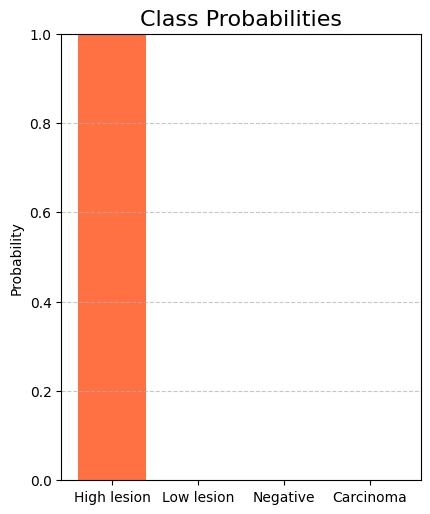

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import Label
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class SimpleImageEvaluatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Simple Image Evaluator")
        self.root.geometry("1000x600")
        self.root.configure(bg="#E0F7FA")  # Màu nền sáng nhẹ

        self.image_path = None
        self.checkpoint_file = None
        self.model = None
        self.predictions = None

        # Left panel - Upload controls
        self.upload_frame = tk.Frame(self.root, bg="#0097A7")  # Màu xanh đậm hơn
        self.upload_frame.pack(side="left", padx=10, pady=10, fill='y')

        # Image upload button
        self.upload_image_button = tk.Button(
            self.upload_frame, text="Upload Image", command=self.select_image,
            bg="#B2EBF2", fg="#006064", font=("Arial", 14), bd=0, padx=10, pady=5
        )
        self.upload_image_button.pack(pady=5)

        # Model checkpoint upload button
        self.upload_model_button = tk.Button(
            self.upload_frame, text="Upload Model Checkpoint", command=self.select_checkpoint,
            bg="#B2EBF2", fg="#006064", font=("Arial", 14), bd=0, padx=10, pady=5
        )
        self.upload_model_button.pack(pady=5)

        # Evaluation button
        self.evaluate_button = tk.Button(
            self.upload_frame, text="Evaluate Image", command=self.evaluate_image,
            bg="#B2EBF2", fg="#006064", font=("Arial", 14), bd=0, padx=10, pady=5
        )
        self.evaluate_button.pack(pady=5)

        # Right panel - Display controls
        self.display_frame = tk.Frame(self.root, bg="#E0F7FA")
        self.display_frame.pack(side="right", padx=10, pady=10, fill='both', expand=True)

        # Image display label
        self.image_label = Label(self.display_frame)
        self.image_label.pack(expand=True)

        # Result display labels
        self.result_label = tk.Label(self.display_frame, text="", font=("Arial", 16), bg="#E0F7FA", fg="#004D40")
        self.result_label.pack(pady=5)

        self.result_prob_label = tk.Label(self.display_frame, text="", font=("Arial", 14), bg="#E0F7FA", fg="#004D40")
        self.result_prob_label.pack(pady=5)

        # Frame for displaying the probability chart
        self.chart_frame = tk.Frame(self.root, bg="#E0F7FA")
        self.chart_frame.pack(side="bottom", padx=10, pady=10, fill='both', expand=True)

    def select_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp")]
        )
        if file_path:
            self.image_path = file_path
            self.display_image(file_path)

    def display_image(self, img_path):
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Đảm bảo ảnh có kích thước phù hợp để hiển thị
        img = ImageTk.PhotoImage(img)
        self.image_label.configure(image=img)
        self.image_label.image = img  # Giữ tham chiếu để tránh bị xoá bởi bộ dọn rác

    def select_checkpoint(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Model Checkpoint", "*.h5"), ("Keras Model", "*.keras")]
        )
        if file_path:
            self.checkpoint_file = file_path

    def evaluate_image(self):
        if not self.image_path or not self.checkpoint_file:
            messagebox.showerror("Error", "Please select both an image and a model checkpoint.")
            return

        # Load model
        try:
            self.model = load_model(self.checkpoint_file)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model from {self.checkpoint_file}: {e}")
            return

        # Load and preprocess the image
        try:
            img = image.load_img(self.image_path, target_size=(224, 224))  # Kích thước đầu vào của mô hình
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, 0)  # Batch size = 1

            # Make prediction
            self.predictions = self.model.predict(img_array)
            predicted_class = np.argmax(self.predictions, axis=1)[0]
            confidence_score = np.max(self.predictions)

            # Display the result
            class_names = [
                'High lesion',
                'Low lesion',
                'Negative',
                'Carcinoma'
            ]
            self.result_label.config(text=f"Predicted: {class_names[predicted_class]}")
            self.result_prob_label.config(text=f"Confidence: {confidence_score:.2f}")

            # Call method to display the chart
            self.plot_probabilities()

        except Exception as e:
            messagebox.showerror("Error", f"Error processing image: {e}")

    def plot_probabilities(self):
        # Clear previous chart if any
        for widget in self.chart_frame.winfo_children():
            widget.destroy()

        # Create a bar chart for probabilities
        fig, ax = plt.subplots()
        ax.bar(['High lesion', 'Low lesion', 'Negative', 'Carcinoma'],  # Trục x
               self.predictions[0], color=['#FF7043', '#FFD54F', '#4DB6AC', '#64B5F6'])  # Trục y
        ax.set_ylim(0, 1)  # Thiết lập giới hạn cho trục y
        ax.set_ylabel('Probability')  # Nhãn cho trục y
        ax.set_title('Class Probabilities', fontsize=16)  # Tiêu đề cho biểu đồ
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Create a canvas to display the chart in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=self.chart_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill='both')

# Main application
if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleImageEvaluatorApp(root)
    root.mainloop()
